# **CSE564: *Reinforcement Learning Assignment-3***

In [1]:
import warnings
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
from utils import episode, TD0, MC, RMS_error

plt.style.use("seaborn-v0_8-darkgrid")
warnings.filterwarnings("ignore")

## **Question: 4**

We solve the blackjack problem and generate the corresponding figures given in the book. Reference has been taken from [Toward Data Science](https://towardsdatascience.com/monte-carlo-methods-estimate-blackjack-policy-fcc89df7f029).

### **Solution**

In [2]:
PLAYER_STATES = np.arange(12, 22)          # Player's current sum (12 – 21)
DEALER_SHOWING_CARDS = np.arange(1, 11)    # Dealer's showing card (ace – 10)
USABLE_ACE = np.arange(2)                  # Whether or not the player holds a usable ace

N_episodes: int = 500000

In [3]:
def draw_card() -> int:
    return np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10])


def move(curr: int, usable_ace: int, target: int, end: bool) -> tuple[int]:
    """
    This function is used to simulate the player's and dealer's move.
    Returns the final value of the hand, whether or not the player holds a usable ace, and whether or not the game has ended.
    """
    if curr > 21:
        if usable_ace:
            curr -= 10
            usable_ace = 0
        else:
            return curr, usable_ace, True
    if curr >= target:
        return curr, usable_ace, True
    else:
        card = draw_card()
        if card == 1:
            if curr <= 10:
                return curr + 11, 1, False
            return curr + 1, usable_ace, False
        else:
            return curr + card, usable_ace, False

In [4]:
V = np.zeros((PLAYER_STATES.shape[0], DEALER_SHOWING_CARDS.shape[0], USABLE_ACE.shape[0]))
record = np.zeros((*V.shape, 2))
j = -1

player = lambda curr, usable_ace, end: move(curr, usable_ace, 20, end)
dealer = lambda curr, usable_ace, end: move(curr, usable_ace, 17, end)

# Monte Carlo simulation
for episode in range(1, N_episodes+1):
    print(f"Episode {str(episode).zfill(5)}", end="\r")
    states, rewards = [], [np.nan]

    # PLAYER'S TURN
    state = [0, draw_card(), 0]
    end = False
    while True:
        state[0], state[2], end = player(state[0], state[2], end)
        if end: break
        if (state[0] >= 12) and (state[0] <= 21):
            states.append(state.copy())
            rewards.append(0)

    # DEALER'S TURN
    dealer_value = state[1] + draw_card()
    usable_ace, end = False, False
    while not end:
        dealer_value, usable_ace, end = dealer(dealer_value, usable_ace, end)

    # MONTE CARLO UPDATE (Since intermediate rewards are 0 and episode is undiscounted, update simply adds R to V)
    ps, ds, ua = states[-1]
    if state[0] > 21:
        if dealer_value <= 21:
            V[ps - 12, ds - 1, ua] -= 1
    else:
        if dealer_value > 21:
            V[ps - 12, ds - 1, ua] += 1
        else:
            if state[0] < dealer_value:
                V[ps - 12, ds - 1, ua] -= 1
            elif state[0] > dealer_value:
                V[ps - 12, ds - 1, ua] += 1

    if episode == 10000 or episode == 500000:
        record[:, :, :, (j := j+1)] = V

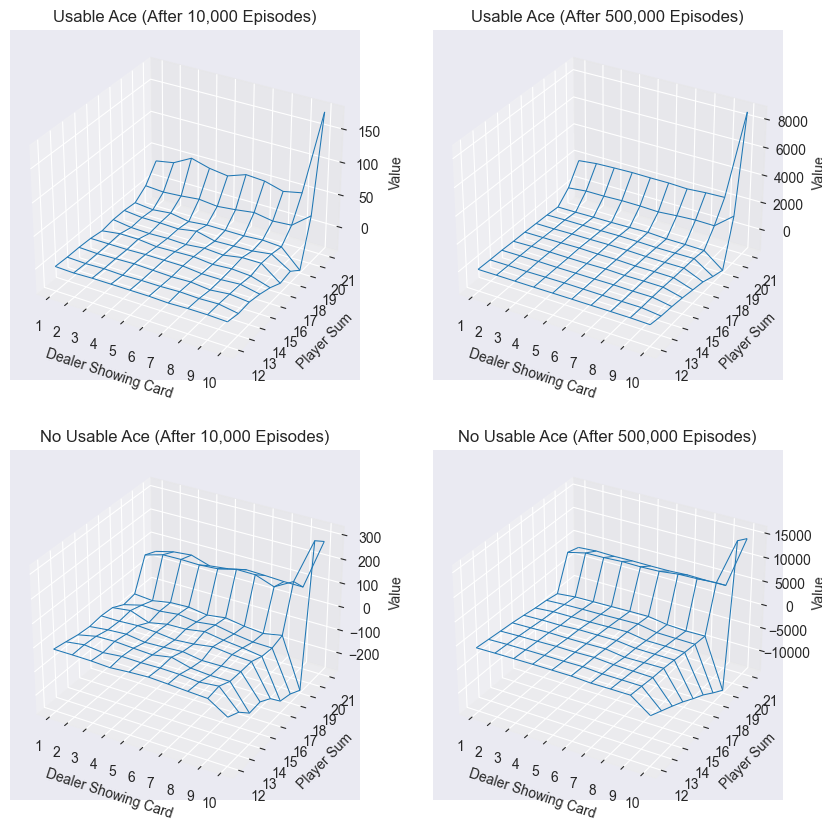

In [5]:
figure = plt.figure(figsize=(10, 10))

X, Y = np.meshgrid(DEALER_SHOWING_CARDS, PLAYER_STATES)

ax1 = figure.add_subplot(2, 2, 1, projection="3d")
ax1.set_title("Usable Ace (After 10,000 Episodes)")
ax1.plot_wireframe(X, Y, record[:, :, 1, 0], linewidth=0.75)

ax2 = figure.add_subplot(2, 2, 2, projection="3d")
ax2.set_title("Usable Ace (After 500,000 Episodes)")
ax2.plot_wireframe(X, Y, record[:, :, 1, 1], linewidth=0.75)

ax3 = figure.add_subplot(2, 2, 3, projection="3d")
ax3.set_title("No Usable Ace (After 10,000 Episodes)")
ax3.plot_wireframe(X, Y, record[:, :, 0, 0], linewidth=0.75)

ax4 = figure.add_subplot(2, 2, 4, projection="3d")
ax4.set_title("No Usable Ace (After 500,000 Episodes)")
ax4.plot_wireframe(X, Y, record[:, :, 0, 1], linewidth=0.75)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks(DEALER_SHOWING_CARDS)
    ax.set_yticks(PLAYER_STATES)
    ax.set_xlabel("Dealer Showing Card")
    ax.set_ylabel("Player Sum")
    ax.set_zlabel("Value")

plt.show()

## **Question: 6**

Generating the figures in Example 6.2, which deals with a Random Walk. We implement `MC` and `TD(0)` techniques to learn the value functions for the given MRP. We then generate the figures of the learning curve and the value function for different number of episodes for the given MRP.

### **Solution**

In [6]:
def policy(state: int) -> int:
    """Return action for a given state."""
    return np.random.choice(actions)

In [7]:
states = np.arange(7)            # A->1, B->2, C->3, D->4, E->5, 0 and 6 are terminal states
actions = np.arange(-1, 2, 2)    # left->-1, right->+1
rewards = lambda s, a: 1 if s == 5 and a == 1 else 0
gamma: float = 1.0

N_episodes: int = 100

#### **Comparison of Estimated Values of States**

In [8]:
v = np.full(len(states), 0.5)               # initial estimates for all states
v[0] = v[-1] = 0.0                          # terminal states
estimates = np.zeros((3, len(states)-2))    # estimates for 3 selected episodes
j = -1
for i in range(1, N_episodes+1):
    v = TD0(states, rewards, policy, gamma, alpha=0.1, V=v)
    if i in (1, 10, 100):
        estimates[(j := j+1)] = v[1:-1]

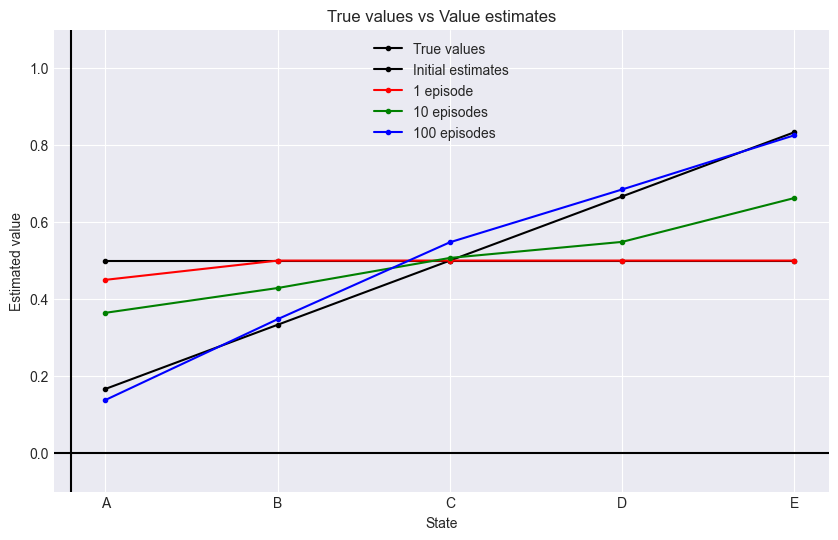

In [9]:
plt.figure(figsize=(10, 6))
plt.title("True values vs Value estimates")

X = np.arange(1, 6) - 0.8

plt.plot(X, [1/6, 2/6, 3/6, 4/6, 5/6], label="True values", color="black", marker=".")
plt.plot(X, np.full(len(X), 0.5), label="Initial estimates", color="black", marker=".")
plt.plot(X, estimates[0], label="1 episode", color="red", marker=".")
plt.plot(X, estimates[1], label="10 episodes", color="green", marker=".")
plt.plot(X, estimates[2], label="100 episodes", color="blue", marker=".")

plt.axhline(y=0, color="black")
plt.axvline(x=0, color="black")

plt.xlabel("State")
plt.ylabel("Estimated value")
plt.xticks(X, ["A", "B", "C", "D", "E"])
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 4.4)

plt.grid(True)
plt.legend()
plt.show()

#### **Empirical RMS error averaged over states and episodes**

In [10]:
v = np.full(len(states), 0.5)               # initial estimates for all states
v[0] = v[-1] = 0.0                          # terminal states
true = np.array([0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0])

TD_errors = np.zeros((3, N_episodes))
MC_errors = np.zeros((4, N_episodes))

for repeat in range(1, 100):
    estimates = np.tile(v, (7, 1))              # estimates for 7 selected episodes
    print(f"Repeat: {str(repeat).zfill(2)}", end="\r")
    for i in range(1, N_episodes+1):
        for j in range(1, 4):
            estimates[j-1] = TD0(states, rewards, policy, gamma, alpha=0.05*j, V=estimates[j-1])
            TD_errors[j-1, i-1] += RMS_error(estimates[j-1], true)
        for j in range(1, 5):
            estimates[j+2] = MC(states, actions, rewards, policy, gamma, alpha=0.01*j, V=estimates[j+2])
            MC_errors[j-1, i-1] += RMS_error(estimates[j+2], true)

TD_errors /= 100
MC_errors /= 100

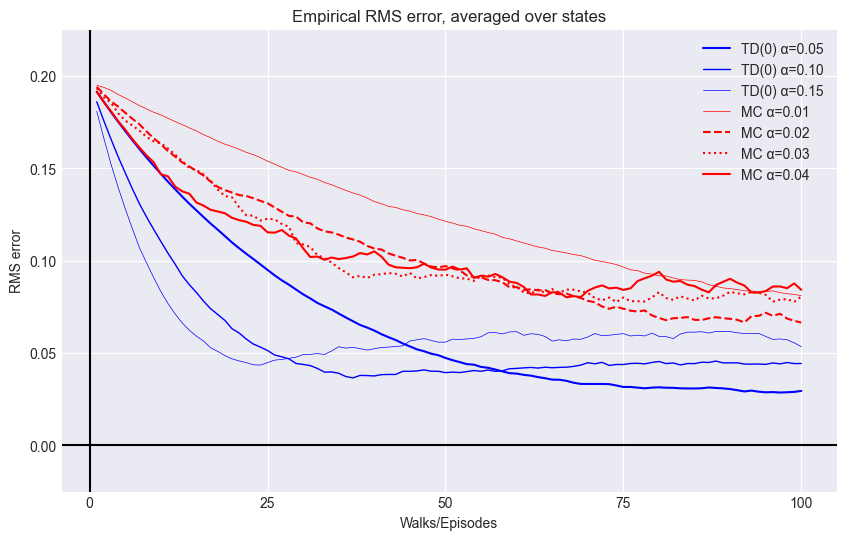

In [11]:
plt.figure(figsize=(10, 6))
plt.title("Empirical RMS error, averaged over states")

X = np.arange(1, N_episodes+1)

plt.plot(X, TD_errors[0], label="TD(0) α=0.05", color="blue", linewidth=1.5)
plt.plot(X, TD_errors[1], label="TD(0) α=0.10", color="blue", linewidth=1.0)
plt.plot(X, TD_errors[2], label="TD(0) α=0.15", color="blue", linewidth=0.5)

plt.plot(X, MC_errors[0], label="MC α=0.01", color="red", linewidth=0.5)
plt.plot(X, MC_errors[1], label="MC α=0.02", color="red", linestyle="--")
plt.plot(X, MC_errors[2], label="MC α=0.03", color="red", linestyle=":")
plt.plot(X, MC_errors[3], label="MC α=0.04", color="red", linewidth=1.5)

plt.axhline(y=0, color="black")
plt.axvline(x=0, color="black")

plt.xlabel("Walks/Episodes")
plt.ylabel("RMS error")
plt.xticks(np.arange(0, 101, 25))
plt.yticks(np.arange(-0.05, 0.25, 0.05))
plt.ylim(-0.025, 0.225)

plt.grid(True)
plt.legend()
plt.show()

## **Question: 7**

Generating the figures to compare the sum of rewards obtained by Q-learning and SARSA. We choose the GridWorld example for cliffwalking to generate the plots.

In [12]:
ROWS: int = 4
COLS: int = 12

START = np.array([3, 0])
TERMINAL = np.array([3, 11])
in_cliff = lambda s: s[0] == 3 and 0 < s[1] < 11

In [13]:
def rewards(s: np.ndarray, a: np.ndarray) -> float:
    """
    Define the reward structure
    """
    if (s[0] == 2 and 0 < s[1] < 11 and a == 2) or (np.array_equal(s, START) and a == 1):
        return -100.0
    else:
        return -1.0


def transition(s: np.ndarray, a: np.ndarray) -> np.ndarray:
    """
    Return the next state given current state and action.
    """
    if a == 0:
        return s + np.array([-1, 0])
    elif a == 1:
        return s + np.array([0, 1])
    elif a == 2:
        return s + np.array([1, 0])
    elif a == 3:
        return s + np.array([0, -1])


def actions(s: np.ndarray) -> np.ndarray:
    """
    Returns the possible actions for a given state.
    """
    valid = []
    if s[0] - 1 >= 0:
        valid.append(0)  # UP
    if s[0] + 1 < ROWS:
        valid.append(2)  # DOWN
    if s[1] - 1 >= 0:
        valid.append(3)  # LEFT
    if s[1] + 1 < COLS:
        valid.append(1)  # RIGHT
    return np.array(valid)


def epsilon_greedy(Q: np.ndarray, s: np.ndarray, eps: float) -> int:
    """
    Return the action using epsilon-greedy policy.
    """
    if np.random.random() < eps:
        return np.random.choice(np.arange(4))
    else:
        return np.argmax(Q[s[0], s[1]])


def Q_learning(Q: np.ndarray, alpha: float, gamma: float, epsilon: float) -> np.ndarray:
    """
    Q-learning algorithm. Returns the Q-table and total reward of the episode
    """
    s = START
    reward = 0
    while not np.array_equal(s, TERMINAL):
        a = epsilon_greedy(Q, s, epsilon)
        s_ = transition(s, a)
        s_ = np.array([np.clip(s_[0], 0, ROWS-1), np.clip(s_[1], 0, COLS-1)])
        reward = reward + (r := rewards(s, a))
        Q[s[0], s[1], a] += alpha * (r + gamma * np.max(Q[s_[0], s_[1]]) - Q[s[0], s[1], a])
        s = START if in_cliff(s_) else s_
    return Q, reward


def SARSA(Q: np.ndarray, alpha: float, gamma: float, epsilon: float) -> np.ndarray:
    """
    SARSA algorithm. Returns the Q-table and total reward of the episode
    """
    s = START
    a = epsilon_greedy(Q, s, epsilon)
    reward = 0
    while not np.array_equal(s, TERMINAL):
        s_ = transition(s, a)
        s_ = np.array([np.clip(s_[0], 0, ROWS-1), np.clip(s_[1], 0, COLS-1)])
        a_ = epsilon_greedy(Q, s_, epsilon)
        reward = reward + (r := rewards(s, a))
        Q[s[0], s[1], a] += alpha * (r + gamma * Q[s_[0], s_[1], a_] - Q[s[0], s[1], a])
        s, a = START if in_cliff(s_) else s_, a_
    return Q, reward

In [14]:
N_episodes: int = 500

alpha: float = 0.01
gamma: float = 1.0
epsilon: float = 0.1
total_rewards = np.zeros((N_episodes, 2))

Q_learn = np.zeros((ROWS, COLS, 4))   # initial estimates for Q-learning
Q_sarsa = np.zeros((ROWS, COLS, 4))   # initial estimates for SARSA

In [15]:
for repeat in range(80):
    print(f"Repeat: {str(repeat).zfill(2)}", end="\r")

    for episode in range(N_episodes):
        Q_learn, rewards_learn = Q_learning(Q_learn, alpha, gamma, epsilon)
        Q_sarsa, rewards_sarsa = SARSA(Q_sarsa, alpha, gamma, epsilon)
        total_rewards[episode] += [rewards_learn, rewards_sarsa]

total_rewards /= 80

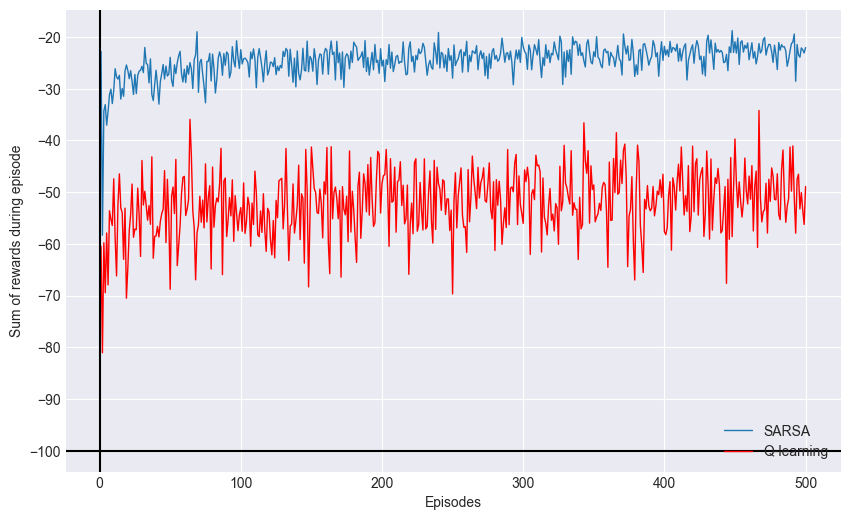

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, N_episodes+1), total_rewards[:, 1], label="SARSA", linewidth=1)
plt.plot(np.arange(1, N_episodes+1), total_rewards[:, 0], label="Q-learning", color="red", linewidth=1)
plt.axhline(y=-100, color="black")
plt.axvline(x=0, color="black")

plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")

plt.grid(True)
plt.legend()
plt.show()